In [1]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import xgboost as xgb

from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 24, 8
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder

sns.set_context(context='notebook')

In [2]:
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc

In [4]:
# Compute gini
@jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

In [5]:
def recon_ps_reg_03(reg):
    integer = int(np.round((40*reg)**2)) # gives 2060 for our example
    for f in range(28):
        if (integer - f) % 27 == 0:
            F = f
    M = (integer - F)//27
    return F, M

In [6]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

In [7]:
def target_encode(trn_series=None,    # Revised to encode validation series
                  val_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)

In [8]:
# Read data
train_df = pd.read_csv('../data/train.csv', na_values="-1") # .iloc[0:200,:]
test_df = pd.read_csv('../data/test.csv', na_values="-1")

In [9]:
train_features = [
    "ps_car_13",  #            : 1571.65 / shadow  609.23
	"ps_reg_03",  #            : 1408.42 / shadow  511.15
	"ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
	"ps_ind_03",  #            : 1219.47 / shadow  230.55
	"ps_ind_15",  #            :  922.18 / shadow  242.00
	"ps_reg_02",  #            :  920.65 / shadow  267.50
	"ps_car_14",  #            :  798.48 / shadow  549.58
	"ps_car_12",  #            :  731.93 / shadow  293.62
	"ps_car_01_cat",  #        :  698.07 / shadow  178.72
	"ps_car_07_cat",  #        :  694.53 / shadow   36.35
	"ps_ind_17_bin",  #        :  620.77 / shadow   23.15
	"ps_car_03_cat",  #        :  611.73 / shadow   50.67
	"ps_reg_01",  #            :  598.60 / shadow  178.57
	"ps_car_15",  #            :  593.35 / shadow  226.43
	"ps_ind_01",  #            :  547.32 / shadow  154.58
	"ps_ind_16_bin",  #        :  475.37 / shadow   34.17
	"ps_ind_07_bin",  #        :  435.28 / shadow   28.92
	"ps_car_06_cat",  #        :  398.02 / shadow  212.43
	"ps_car_04_cat",  #        :  376.87 / shadow   76.98
	"ps_ind_06_bin",  #        :  370.97 / shadow   36.13
	"ps_car_09_cat",  #        :  214.12 / shadow   81.38
	"ps_car_02_cat",  #        :  203.03 / shadow   26.67
	"ps_ind_02_cat",  #        :  189.47 / shadow   65.68
	"ps_car_11",  #            :  173.28 / shadow   76.45
	"ps_car_05_cat",  #        :  172.75 / shadow   62.92
	"ps_calc_09",  #           :  169.13 / shadow  129.72
	"ps_calc_05",  #           :  148.83 / shadow  120.68
	"ps_ind_08_bin",  #        :  140.73 / shadow   27.63
	"ps_car_08_cat",  #        :  120.87 / shadow   28.82
	"ps_ind_09_bin",  #        :  113.92 / shadow   27.05
	"ps_ind_04_cat",  #        :  107.27 / shadow   37.43
	"ps_ind_18_bin",  #        :   77.42 / shadow   25.97
	"ps_ind_12_bin",  #        :   39.67 / shadow   15.52
	"ps_ind_14",  #            :   37.37 / shadow   16.65
    #'ps_reg_F',
    #'ps_reg_M'
]
# add combinations
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
]


In [10]:
# interaction_features = ['ps_car_13', 'ps_reg_03', 'ps_car_14','ps_ind_03', 'ps_reg_01', 'ps_car_04_cat']
# combs  = list(combinations(interaction_features, 2))

In [11]:
# combs = [
#     ('ps_reg_01', 'ps_car_02_cat'),  
#     ('ps_reg_01', 'ps_car_04_cat'),
#     ('ps_reg_F', 'ps_reg_M'),
# ]

In [12]:
# # Add 'ps_reg_03' reconstruction
# train_df['ps_reg_03'] = train_df['ps_reg_03'].fillna(-1)
# test_df['ps_reg_03'] = test_df['ps_reg_03'].fillna(-1)

# train_df['ps_reg_F'] = train_df['ps_reg_03'].apply(lambda x: recon_ps_reg_03(x)[0] if x!=-1 else -1)
# train_df['ps_reg_M'] = train_df['ps_reg_03'].apply(lambda x: recon_ps_reg_03(x)[1] if x!=-1 else -1)

# test_df['ps_reg_F'] = test_df['ps_reg_03'].apply(lambda x: recon_ps_reg_03(x)[0] if x!=-1 else -1)
# test_df['ps_reg_M'] = test_df['ps_reg_03'].apply(lambda x: recon_ps_reg_03(x)[1] if x!=-1 else -1)

In [13]:
test_df.isnull().sum().divide(test_df.shape[0])[test_df.isnull().sum()>0]

ps_ind_02_cat    0.000344
ps_ind_04_cat    0.000162
ps_ind_05_cat    0.009756
ps_reg_03        0.181094
ps_car_01_cat    0.000179
ps_car_02_cat    0.000006
ps_car_03_cat    0.690972
ps_car_05_cat    0.448423
ps_car_07_cat    0.019412
ps_car_09_cat    0.000982
ps_car_11        0.000001
ps_car_14        0.071465
dtype: float64

In [14]:
train_df.isnull().sum().divide(train_df.shape[0])[train_df.isnull().sum()>0]

ps_ind_02_cat    0.000363
ps_ind_04_cat    0.000139
ps_ind_05_cat    0.009760
ps_reg_03        0.181065
ps_car_01_cat    0.000180
ps_car_02_cat    0.000008
ps_car_03_cat    0.690898
ps_car_05_cat    0.447825
ps_car_07_cat    0.019302
ps_car_09_cat    0.000956
ps_car_11        0.000008
ps_car_12        0.000002
ps_car_14        0.071605
dtype: float64

In [15]:
# Process data
id_test = test_df['id'].values
id_train = train_df['id'].values
y = train_df['target']

start = time.time()
for n_c, (f1, f2) in enumerate(combs):
    name1 = f1 + "_plus_" + f2
    print('\nCurrent feature %60s %4d in %5.1f'
          % (name1, n_c + 1, (time.time() - start) / 60), end='')
    print('\r' * 75, end='')
    train_df[name1] = train_df[f1].apply(lambda x: str(x)) + "_" + train_df[f2].apply(lambda x: str(x))
    test_df[name1] = test_df[f1].apply(lambda x: str(x)) + "_" + test_df[f2].apply(lambda x: str(x))
    # Label Encode
    lbl = LabelEncoder()
    lbl.fit(list(train_df[name1].values) + list(test_df[name1].values))
    train_df[name1] = lbl.transform(list(train_df[name1].values))
    test_df[name1] = lbl.transform(list(test_df[name1].values))

    train_features.append(name1)
    



Current feature                                 ps_reg_01_plus_ps_car_02_cat    1 in   0.0
Current feature                                 ps_reg_01_plus_ps_car_04_cat    2 in   0.0

In [16]:
X = train_df[train_features]
test_df = test_df[train_features]

f_cats = [f for f in X.columns if "_cat" in f]

In [17]:
X = X.fillna(-1)
test_df = test_df.fillna(-1)
y_valid_pred = 0*y
y_test_pred = 0

In [18]:
K = 5
kf = KFold(n_splits = K, random_state = 1, shuffle = True)
np.random.seed(42)

In [35]:
MAX_ROUNDS = 2520 #220
OPTIMIZE_ROUNDS = True
LEARNING_RATE = 0.07
EARLY_STOPPING_ROUNDS = 76

In [36]:
#optimized with lower learning rate
params = {'tree_method':'gpu_hist', 'predictor':'gpu_predictor'}

model = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=0.07,
                        max_delta_step=1.8,
                        subsample=.8,
                        min_child_weight=0.83318,
                        colsample_bytree= 0.8,
                        #min_child_weight=28,#??
                        colsample_bylevel=0.432,#??
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                        n_jobs=12,
                        missing=-1,
                        **params
                     )

In [37]:
# Run CV

for i, (train_index, test_index) in enumerate(kf.split(X)):
    
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
    X_test = test_df.copy()
    print( "\nFold ", i)
    
    # Enocode data
    for f in f_cats:
        X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                                        trn_series=X_train[f],
                                                        val_series=X_valid[f],
                                                        tst_series=X_test[f],
                       
            target=y_train,
                                                        min_samples_leaf=200,
                                                        smoothing=10,
                                                        noise_level=0
                                                        )
    features_list=X_train.columns.tolist()
    # Run model for this fold
    if OPTIMIZE_ROUNDS:
        eval_set=[(X_valid,y_valid)]
        fit_model = model.fit( X_train, y_train, 
                               eval_set=eval_set,
                               eval_metric=gini_xgb,
                               early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                               verbose=False
                             )
        print( "  Best N trees = ", model.best_ntree_limit )
        print( "  Best gini = ", model.best_score )
    else:
        fit_model = model.fit( X_train, y_train )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "  Gini = ", eval_gini(y_valid, pred) )
    y_valid_pred.iloc[test_index] = pred
    
    # Accumulate test set predictions
    y_test_pred += fit_model.predict_proba(X_test)[:,1]
    
    del X_test, X_train, X_valid, y_train
    
y_test_pred /= K  # Average test set predictions

print( "\nGini for full training set:" )
eval_gini(y, y_valid_pred)


Fold  0
  Best N trees =  298
  Best gini =  -0.283663
  Gini =  0.2825302692168188

Fold  1
  Best N trees =  426
  Best gini =  -0.283351
  Gini =  0.2824736093558664

Fold  2
  Best N trees =  294
  Best gini =  -0.273674
  Gini =  0.2729771495950678

Fold  3
  Best N trees =  353
  Best gini =  -0.301464
  Gini =  0.3004374430219976

Fold  4
  Best N trees =  351
  Best gini =  -0.28617
  Gini =  0.28518120070033304

Gini for full training set:


0.28453789055893786

## To beat
Fold  0
  Gini =  0.28577479476034384

Fold  1
  Gini =  0.2820181021610354

Fold  2
  Gini =  0.27447821899775116

Fold  3
  Gini =  0.3002858171526739

Fold  4
  Gini =  0.28670001163168546

Gini for full training set:

0.285616567975407
_________________________
with col_sample_by_level

Fold  0
  Gini =  0.28217460910486425

Fold  1
  Gini =  0.2845180638191228

Fold  2
  Gini =  0.2741347400960207

Fold  3
  Gini =  0.3013526092179516

Fold  4
  Gini =  0.2849336873930929

Gini for full training set:

0.2851963125310223

In [21]:
# Create submission file
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = y_test_pred
filename = 'model_'+str(dt.datetime.now()).replace(' ','_').replace(':','').replace('.','')
sub.id = sub.id.astype('Int32')
sub.to_csv('../output/'+filename+'.csv', index=False)

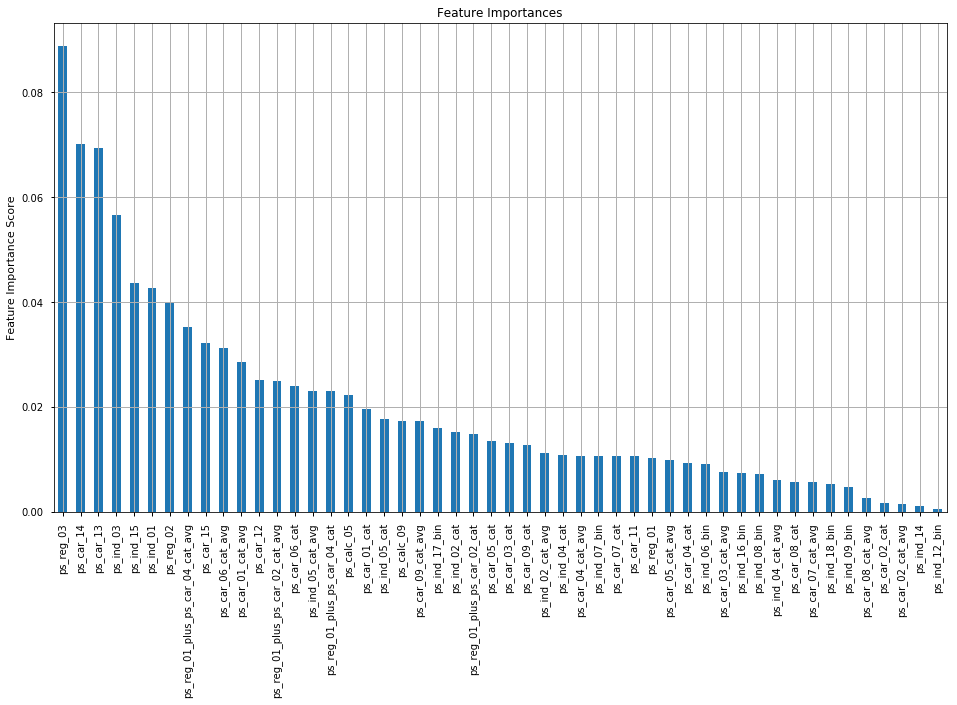

In [46]:
feat_imp = pd.Series(fit_model.feature_importances_).sort_values(ascending=False)
feat_imp.rename(index={i:features_list[i] for i in feat_imp.index.tolist()}, inplace=True)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(16,9))
plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()